In [14]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import pickle
import scipy.io
from os.path import dirname, abspath
import os
import sys
sys.path.append(dirname(dirname(dirname(abspath('__file__')))))

from utils.plr_segmentation import PLR_seg_reg, PLR_seg_inter, draw_segments
from utils.read_answers import ReadAnswers
from utils.check_performance import checkPerformance

from matplotlib.lines import Line2D

%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
## Input the filenames and parameters:
filename = 'AmsData_lage_measurements_all.pkl'
original_indices = 'orig_x.npy'
filename_answers = 'lage_segm_lines_31052020.txt'
interpolation_method = 'linear'
filename_stds = 'stds.pkl'

In [8]:
## Create variables with directories to external files:
directory = os.path.join(dirname(dirname(os.getcwd())), 'data_files/')
file_data = os.path.join(directory, filename)
file_orig_indices = os.path.join(directory, original_indices)
file_answers = os.path.join(directory, filename_answers)
file_stds = os.path.join(directory, filename_stds)

In [10]:
## Import the measurements:
data_imported = pd.read_pickle(file_data)
data = data_imported[interpolation_method].copy()

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
answers = ReadAnswers(file_answers)
ans = pd.DataFrame(answers['segm_lines'], index = answers.index)
ans.columns = ['segm']
## For full time T-S:
ans_full = ans.copy()
for i in range(100):
    ans_full.segm.iloc[i] = [indices[y] for y in ans_full.segm.iloc[i]]

## Mask to choose only the examples with provided GT (ground truth):
mask_segm = ans.segm.apply(lambda x: x != [])
ans[mask_segm]
ans_segm_only = ans.iloc[np.where(mask_segm)[0]]
mydata_segm_only = data.iloc[ans.index[np.where(mask_segm)[0]]].copy()

## Load standadr deviation values for all T-S:
with open(file_stds, 'rb') as file:
    stds = pickle.load(file)
std_al_orig, std_al_detr, atd_ah_orig, std_ah_detr = stds


/home/dominik/insar-msc/utils/PLR_segment/wrappers.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = lstsq(A,y)


ans:  segm    [87, 39, 24]
Name: 137, dtype: object


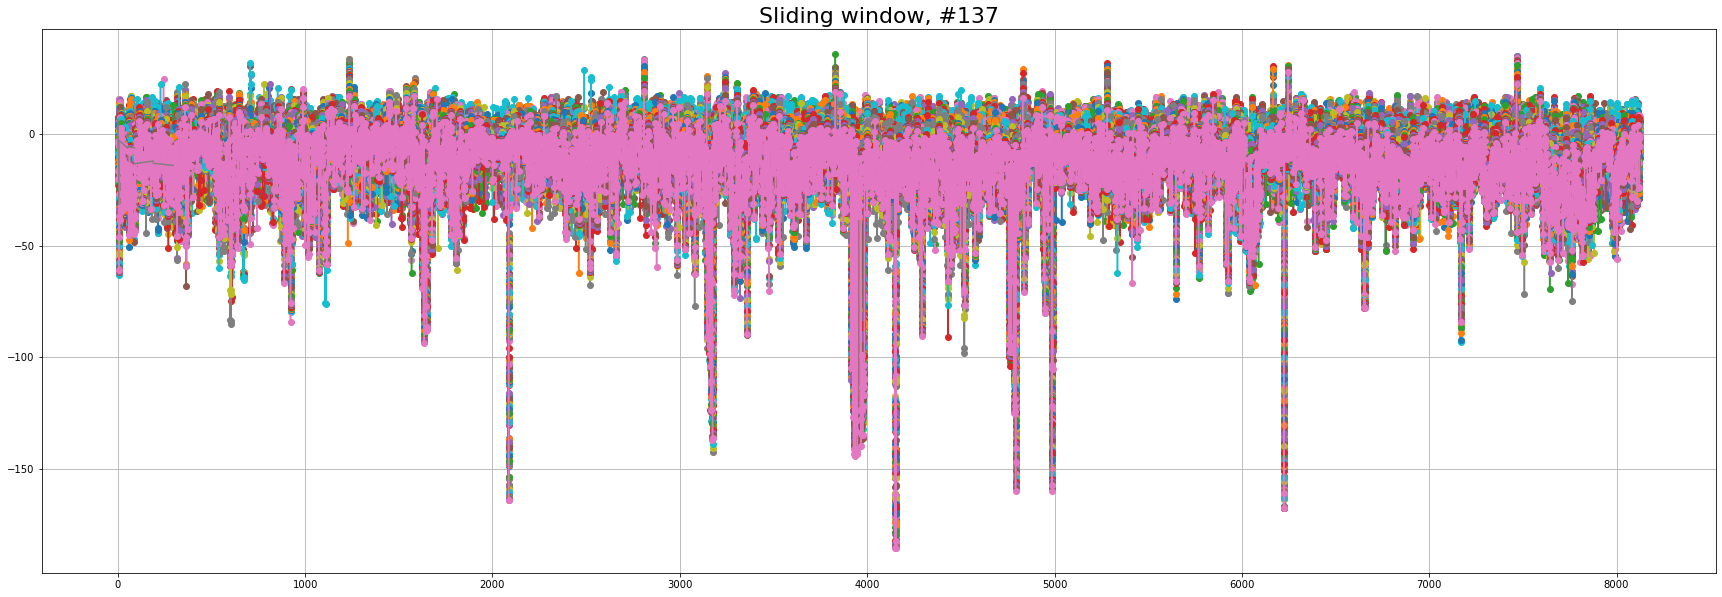

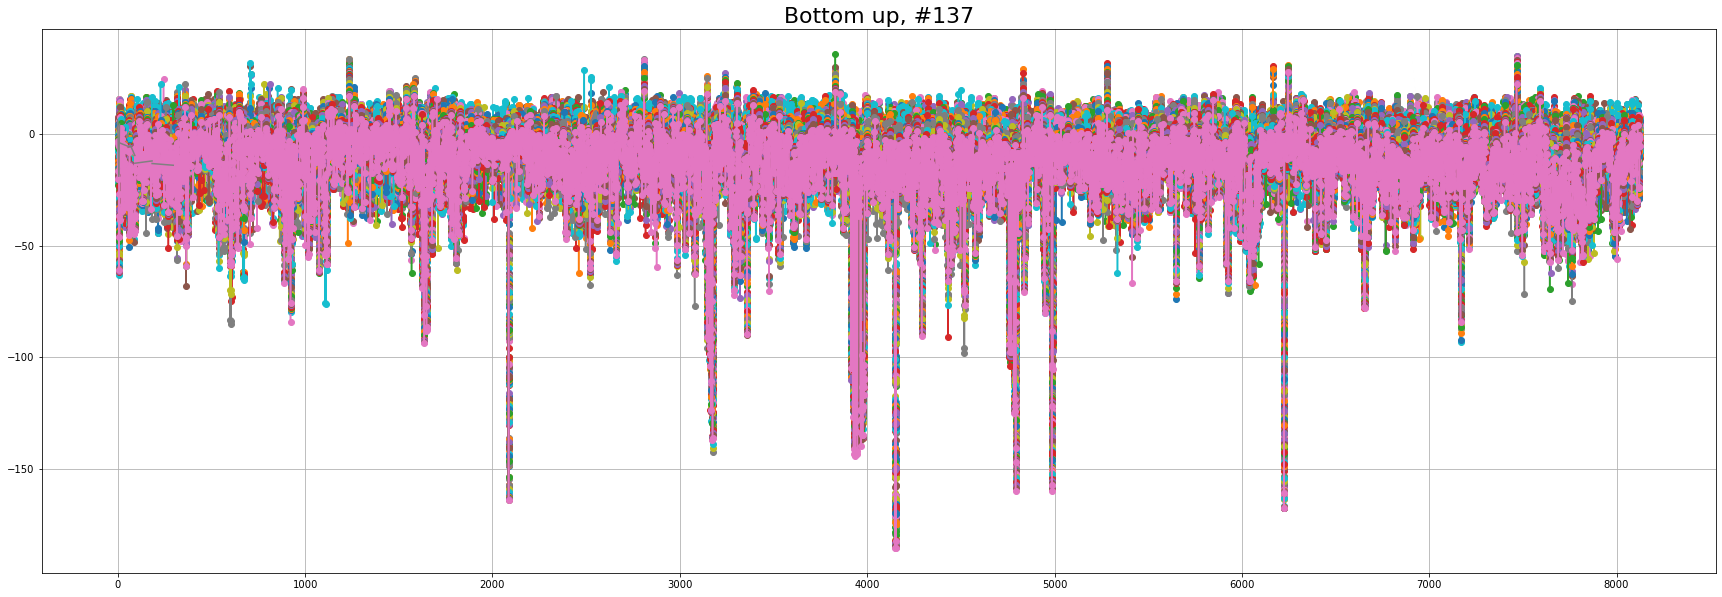

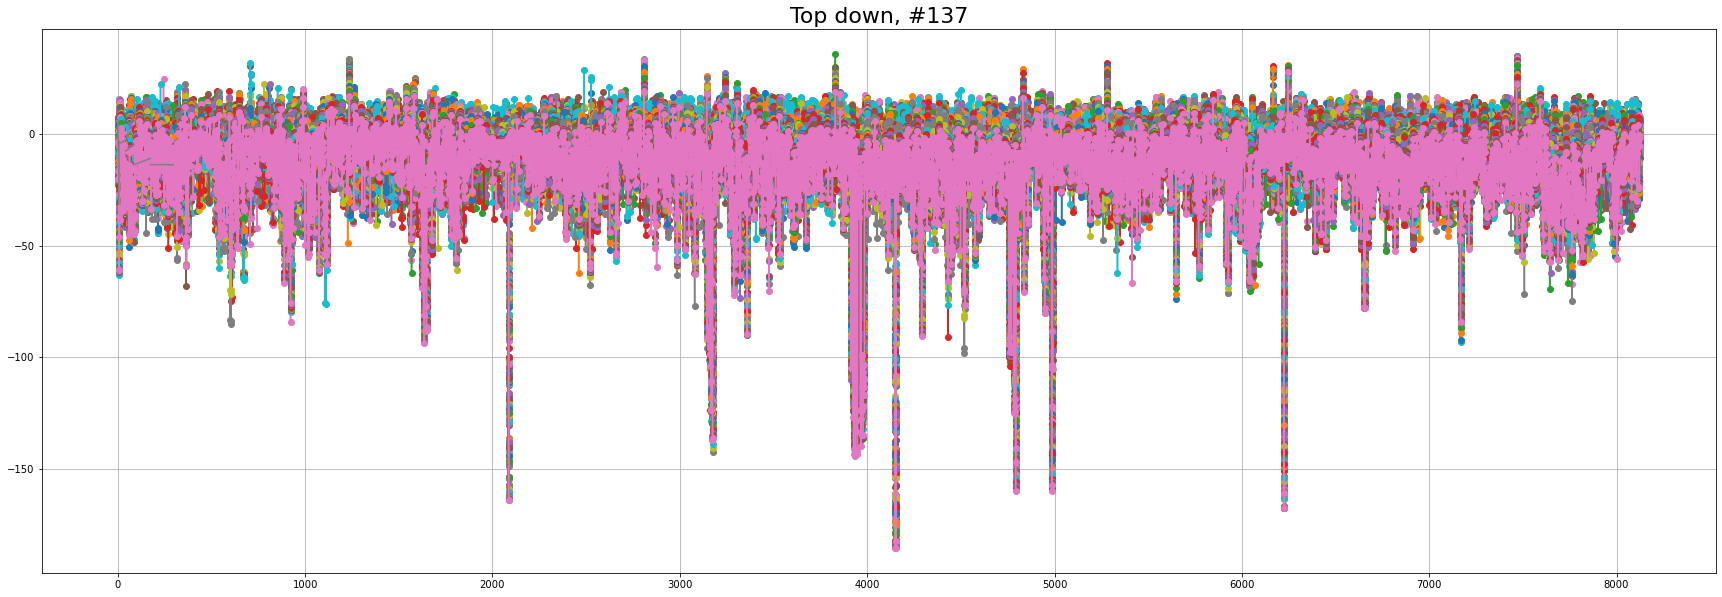

In [11]:
ts_num = 2
max_error = 500

plr_reg, _ = PLR_seg_reg(data.iloc[ans.index[ts_num]].values, max_error)

## For T-S with missing observations:
# print("ans: ", ans.iloc[ts_num])
# print("ans: ", [indices[x] for x in ans.iloc[ts_num].values[0]])

## For full time T-S:
print("ans: ", ans_full.iloc[ts_num])


plt.figure(figsize=(30,10))
plt.plot(data, '-o')
draw_segments(plr_reg[1])
plt.title('Sliding window, #' + str(ans.index[ts_num]), fontsize=22)
plt.grid()
plt.show()

plt.figure(figsize=(30,10))
plt.plot(data, '-o')
draw_segments(plr_reg[0])
plt.title('Bottom up, #' + str(ans.index[ts_num]), fontsize=22)
plt.grid()
plt.show()

plt.figure(figsize=(30,10))
plt.plot(data, '-o')
draw_segments(plr_reg[2])
plt.title('Top down, #' + str(ans.index[ts_num]), fontsize=22)
plt.grid()
plt.show()

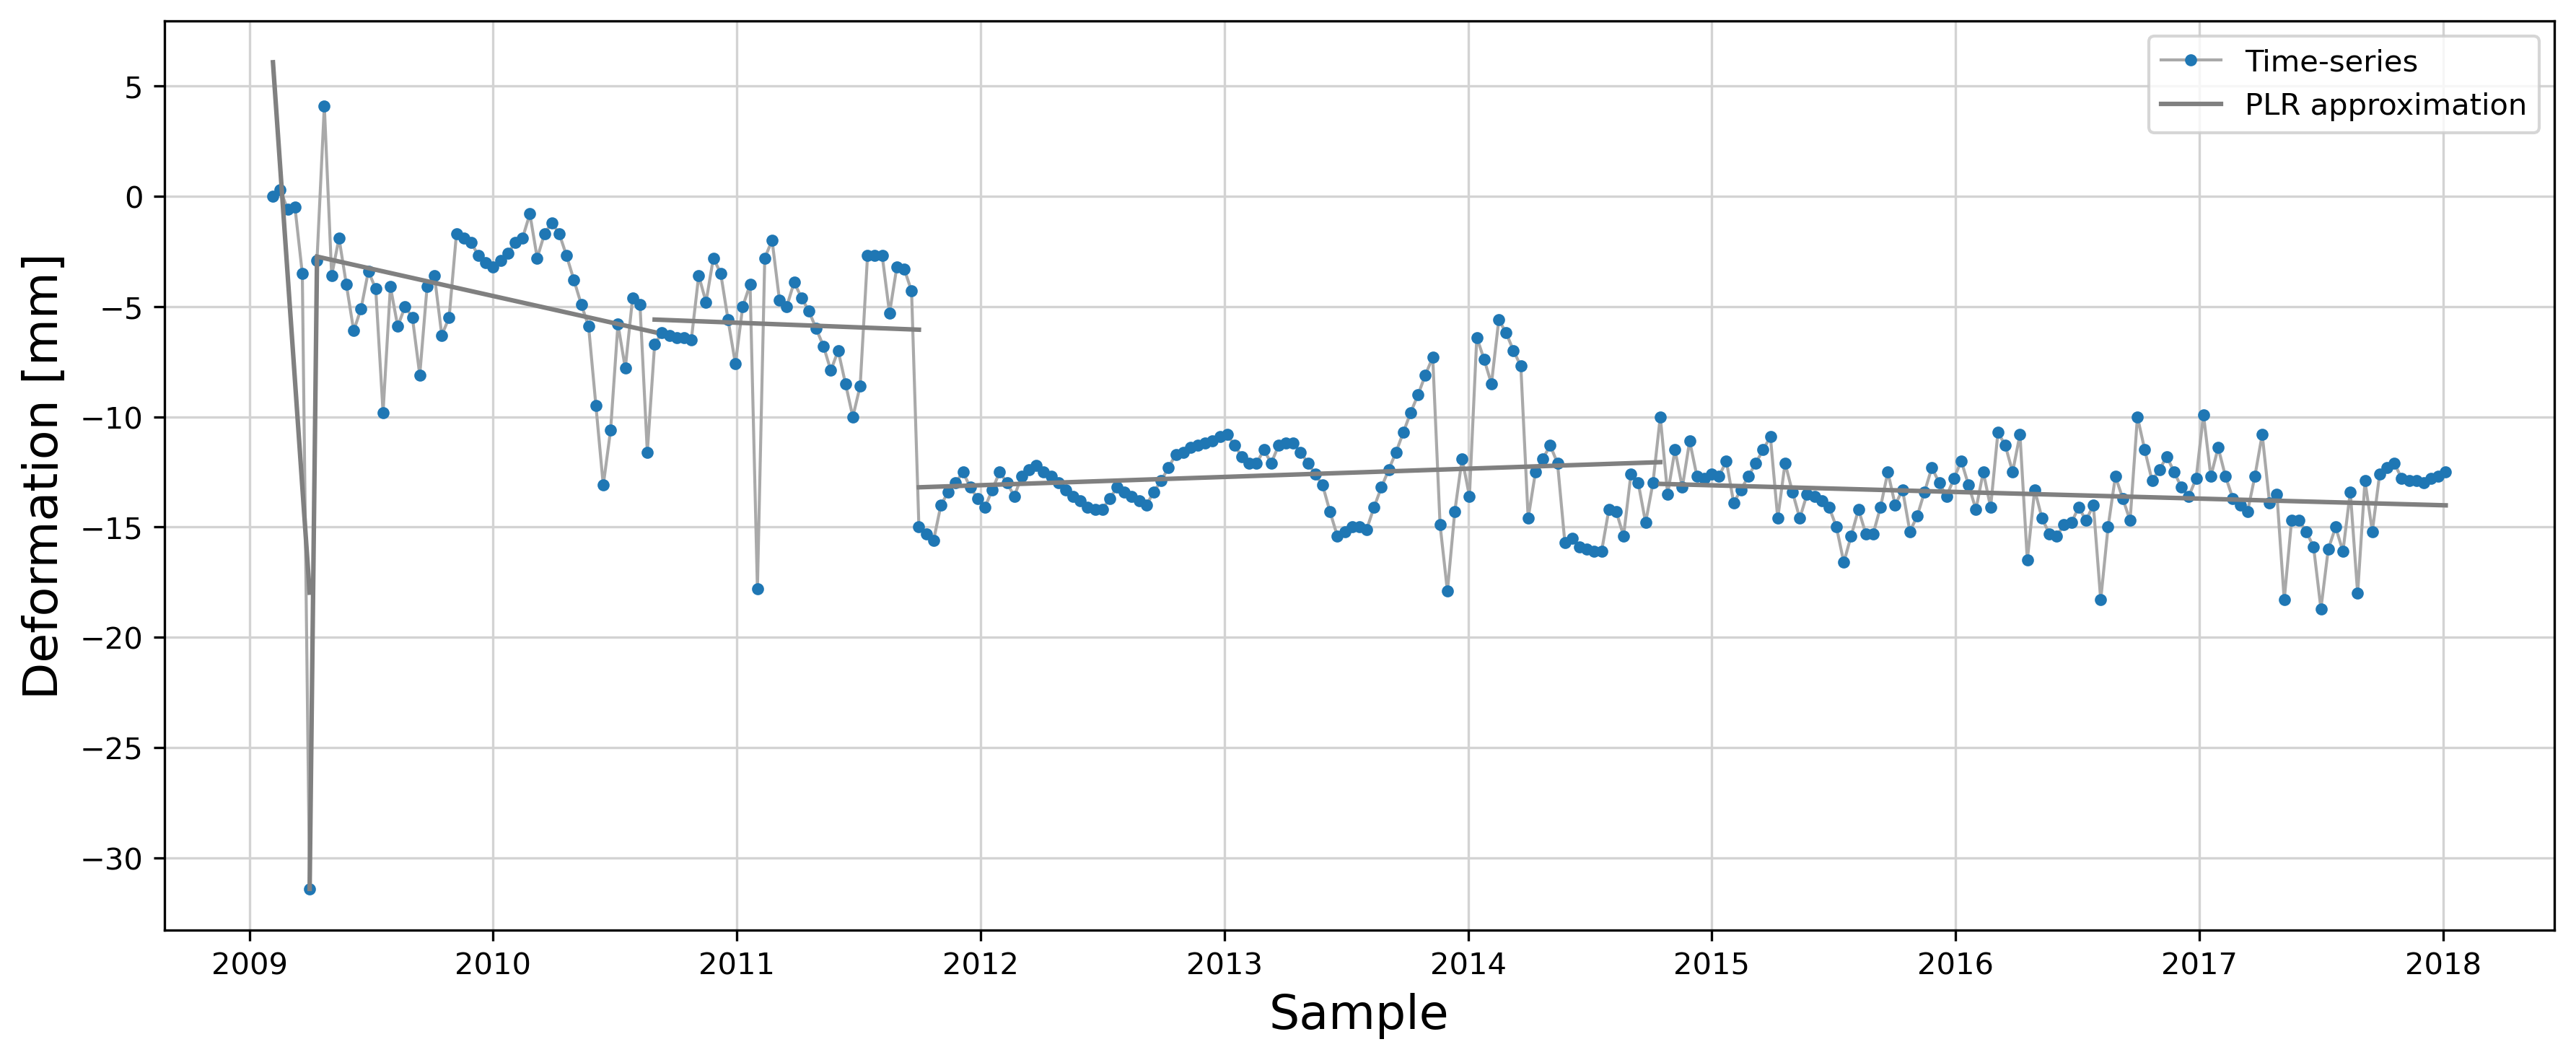

In [16]:
## T-S number (original index):
ts_num = 137

## PLR segmentation to be plotted:
segments = plr_reg[1]

fig = plt.figure(figsize=(12,5), dpi=300)
ax = plt.gca()

ax.set_xlabel("Sample", fontsize=16)
ax.set_ylabel("Deformation [mm]", fontsize=16)
ax.grid(True, color="lightgrey")
ax.set_axisbelow(True)
# ax.plot(mydata.columns, mydata.iloc[ts_num, :].T, '-o', markersize=3, linewidth=1, color='#D0D0D0', markerfacecolor='C0', markeredgecolor='C0')

## T-S w/ MO:
# ax.plot(indices, mydata.iloc[ts_num, :].T, '-o', markersize=3, linewidth=1, color='darkgrey', markerfacecolor='C0', markeredgecolor='C0')
## T-S w/o MO:
# ax.plot(range(len(mydata.columns)), mydata.iloc[ts_num, :].T, '-o', markersize=3, linewidth=1, color='darkgrey', 
#         markerfacecolor='C0', markeredgecolor='C0')
ax.plot(data.columns, data.iloc[ts_num, :].T, '-o', markersize=3, linewidth=1, color='darkgrey', 
        markerfacecolor='C0', markeredgecolor='C0')

for segment_i in segments:
#     line = Line2D((indices[segment_reg[0]],indices[segment_reg[2]]),(segment_reg[1],segment_reg[3]), color = "grey")    # T-S w/ MO
#     line = Line2D((segment_i[0],segment_i[2]),(segment_i[1],segment_i[3]), color = "grey")    # T-S w/o MO, samples index
    line = Line2D((data.columns[segment_i[0]],data.columns[segment_i[2]]),
                  (segment_i[1],segment_i[3]), color = "grey")   # T-S w/o MO, time index
    ax.add_line(line)    

fig.tight_layout()
ax.legend(["Time-series", "PLR approximation"])

### Save the plot ###
    
# fig.savefig(str(ts_num) +'_PLR_reg.jpg', bbox_inches="tight")    
plt.show()